# Data Simulations EDA

## Import modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", message=r"elementwise", category=FutureWarning)

## Import DataCreator class

In [2]:
from DataReader import DataReader

## Data Exploration

In [3]:
data_instance = DataReader()

In [13]:
N_Ref = 500000
N_Bkg = 3000
N_Sig = 0

In [14]:
REF_RUN = 1252
DATA_RUN = 1253

ref_df = data_instance.build_sample(file_name=f'RUN00{REF_RUN}_cut_shifted_hstat_condor.txt', n_data=N_Ref)
# data_instance.save_distribution('reference_distribution.txt')

data_df = data_instance.build_sample(file_name=f'RUN00{DATA_RUN}_cut_shifted_hstat_condor.txt', n_data=N_Bkg)
# data_instance.save_distribution('data_distribution.txt')

### Method 1

In [17]:
data_df = data_df + 90

ref_target = np.zeros(N_Ref)
data_target = np.ones(N_Bkg+N_Sig)
target = np.append(ref_target, data_target)
target = np.expand_dims(target, axis=1)

In [18]:
feature = np.concatenate((ref_df, data_df), axis=0)
feature = np.expand_dims(feature, axis=1)
feature = np.concatenate((feature, target), axis=1)
np.random.shuffle(feature)

In [19]:
dataF = pd.DataFrame({'feature':feature[:, 0], 'target':feature[:, -1]})
dataF.loc[(dataF['target']==0, 'Distribution')] = 'REF'
dataF.loc[(dataF['target']==1, 'Distribution')] = 'DATA'

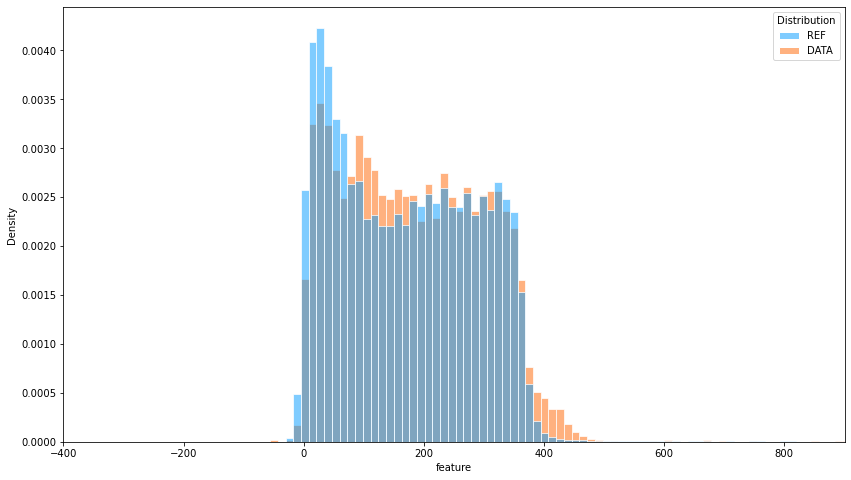

In [79]:
# creo figure&axes
fig, ax = plt.subplots(figsize=(14,8))

ax=sns.histplot(data=dataF, x='feature', hue='Distribution', stat='density', element='bars', fill=True, common_norm=False,
             common_bins=True, bins = 100, palette=['#009AFF', '#ff6500'], edgecolor='white', multiple='layer', hue_order=['REF', 'DATA'])

ax.set_xlim(-400, 900)

plt.show()

### Method 2

In [16]:
ref_hist, ref_bins = np.histogram(ref_df, bins=100, density=False)
data_hist, data_bins = np.histogram(data_df, bins=100, density=False)

In [17]:
def middle_point(array):
    mid_points = [(array[i]+array[i+1])/2 for i in np.arange(len(array)-1)]
    return np.array(mid_points)

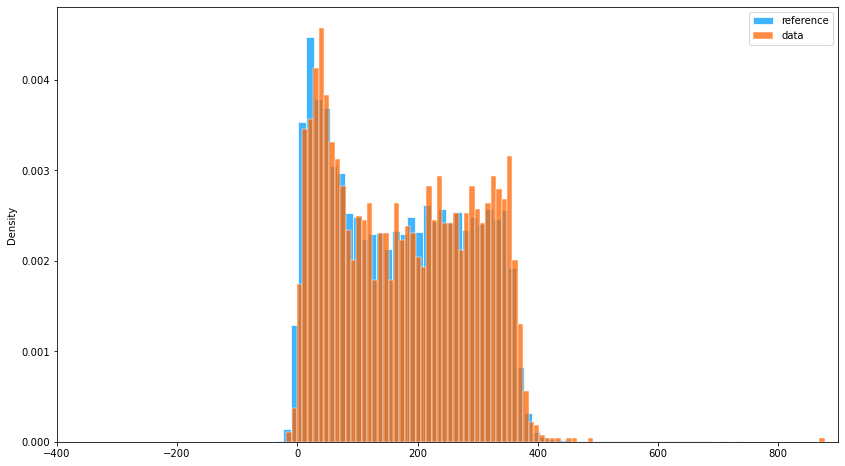

In [18]:
# creo figure&axes
fig, ax = plt.subplots(figsize=(14,8))

# istogramma reference
ax = sns.histplot(x=middle_point(ref_bins),  bins=ref_bins, weights=ref_hist,
                  stat='density', element='bars', fill=True, color='#009cff', edgecolor='white', zorder=0, label='reference')


# istogramma data
ax = sns.histplot(x=middle_point(data_bins),  bins=data_bins, weights=data_hist,
                  stat='density', element='bars', fill=True, color='#ff6500', edgecolor='white', zorder=1, label='data')

ax.set_xlim(-400, 900)

ax.legend()
plt.show()

# SAMPLE PLOTS

In [171]:
def read_data(file_name, n_data, shift):
    df=pd.read_csv(file_name, sep=' ')
    df=df.sample(n=n_data)
    return df['DRIFT_TIME']+shift

In [172]:
def mask(df, left, right):
    return df[(df > left) & (df < right)]

In [201]:
REFERENCE_FILE = "/lustre/cmswork/nlai/DATA/drift_distributions/RUN001252_raw_hstat_condor.txt"
RUN = 1242
DATA_FILE = f"/lustre/cmswork/nlai/DATA/drift_distributions/RUN00{RUN}_raw_hstat_condor.txt"
N_Ref = 200000
N_Data = 3000

REF_DF = read_data(file_name=REFERENCE_FILE, n_data=N_Ref, shift=120)
DATA_DF = read_data(file_name=DATA_FILE, n_data=N_Data, shift=145)

In [202]:
left_bound = -90
right_bound = 530

REF_DF = mask(REF_DF, left_bound, right_bound)
DATA_DF = mask(DATA_DF, left_bound, right_bound)

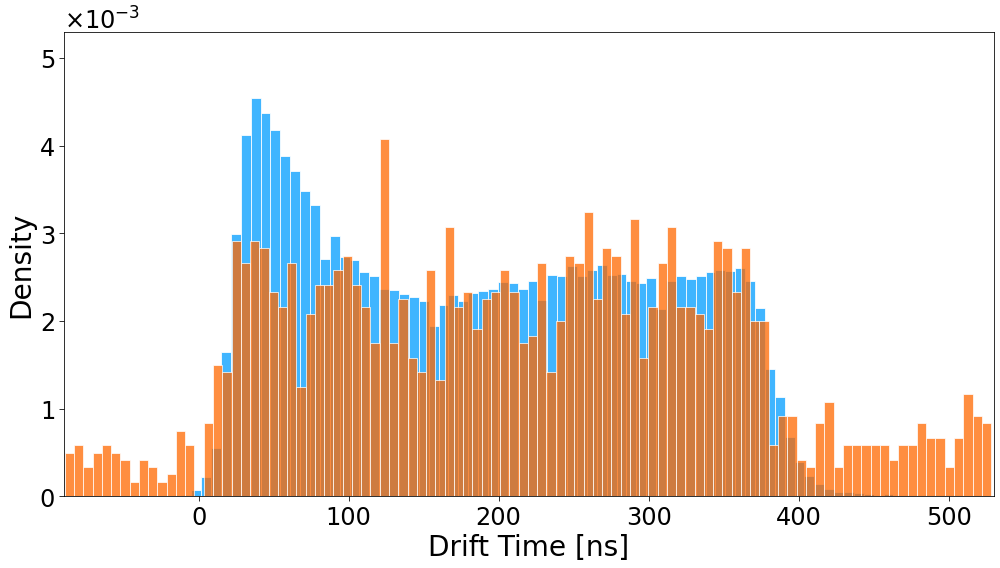

In [203]:
from matplotlib.ticker import ScalarFormatter

fig, ax = plt.subplots(figsize=(14,8))

ax = sns.histplot(x=REF_DF,  bins=90, stat='density', element='bars', fill=True, color='#009cff', edgecolor='white')
ax = sns.histplot(x=DATA_DF,  bins=100, stat='density', element='bars', fill=True, color='#FF6800', edgecolor='white')

ax.set_xlim(left_bound, right_bound)
ax.set_ylim(0, 5.3*1e-3)
# ax.set_title(f'Drift Time Distribution - RUN{run_number}', fontsize = 32)
ax.set_xlabel('Drift Time [ns]', fontsize = 28)
ax.set_ylabel('Density', fontsize = 28)
ax.tick_params(axis = 'both', which = 'major', labelsize = 24, direction = 'out', length = 5)
ax.yaxis.get_offset_text().set_fontsize(24)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
fig.tight_layout()

# plot_name="sampled_ref"
# fig.savefig(f'/lustre/cmswork/nlai/PLOTS/DRIFT_TIME/thesis/{plot_name}.pdf', facecolor = 'white')

plt.show()

In [204]:
from scipy.stats import ks_2samp

d, p = ks_2samp(REF_DF, DATA_DF, alternative='two-sided')

print(p)

2.451399836749892e-11


In [7]:
def change_legend(ax, new_loc, fontsize, titlesize, **kws):
        '''funzione per modificare posizione e font size della legenda generata da seaborn'''

        old_legend = ax.legend_
        handles = old_legend.legendHandles
        labels = [t.get_text() for t in old_legend.get_texts()]
        title = old_legend.get_title().get_text()

        ax.legend(handles, labels, loc=new_loc, title=title, fontsize=fontsize, title_fontsize=titlesize, frameon = True, fancybox = False, framealpha = 0.5, **kws)

        return

In [1]:
import os
import h5py
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter

In [3]:
DOF = 10
chi_dist = scipy.stats.chi2.rvs(df=DOF, scale=1, loc=0, size=400)

In [4]:
path = "/lustre/cmswork/nlai/DATA/"
name = "t_reference.txt"
np.savetxt(fname=path+name, X=chi_dist)

In [5]:
BINS = 8
XMIN = 0
XMAX = max(chi_dist) + min(chi_dist)
XGRID = np.linspace(XMIN, XMAX, 500)

/lustre/cmswork/nlai/anaconda/lib/python3.8/site-packages/seaborn/distributions.py:365: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"


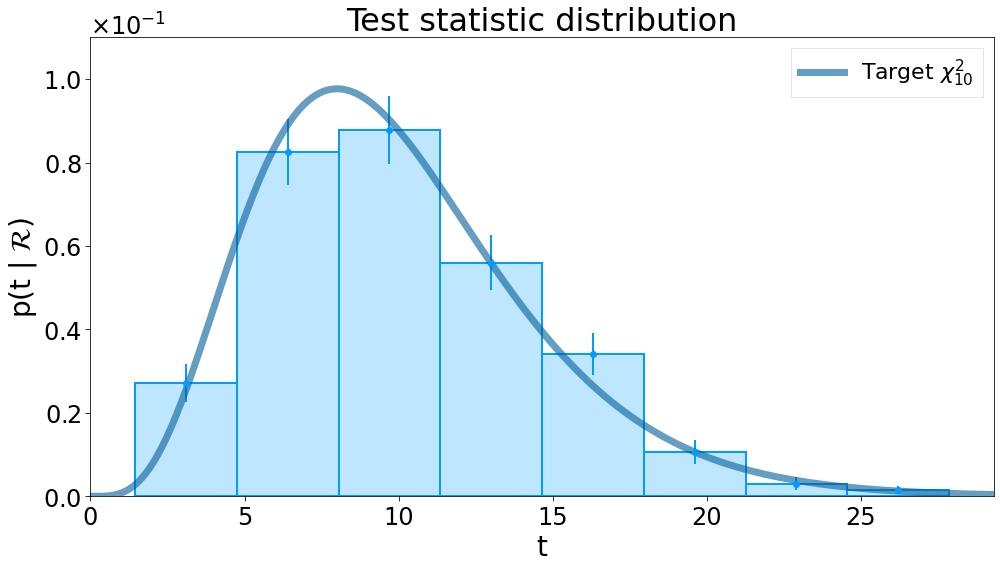

In [11]:
fig, ax = plt.subplots(figsize=(14,8))

hist, bin_edges = np.histogram(chi_dist, density=True, bins=BINS)

binswidth = bin_edges[1]-bin_edges[0]
central_points = [
    (bin_edges[i] + bin_edges[i + 1]) / 2 for i in range(len(bin_edges) - 1)
]
err = np.sqrt(hist/(chi_dist.shape[0]*binswidth))

ax.plot(
    XGRID, scipy.stats.chi2.pdf(XGRID, df=DOF), 
    color='#005e99', linestyle='solid', linewidth=7, alpha=0.6, 
    label=r'Target $\chi^{2}_{10}$'
)

sns.histplot(
    x=bin_edges[:-1], weights=hist, bins=bin_edges,
    stat='density', element='bars', linewidth=2,
    fill=True, color='#aadeff', edgecolor='#009cff', 
    ax=ax
)

ax.errorbar(central_points, hist, yerr=err, color='#009cff', linewidth=2, marker='o', ls='')

ax.set_title(f'Test statistic distribution', fontsize = 32)
ax.set_xlabel('t', fontsize = 28)
ax.set_ylabel(r'p(t | $\mathcal{R}$)', fontsize = 28)
    
ax.set_xlim(XMIN, XMAX)
ax.set_ylim(0, 0.11)

ax.tick_params(axis = 'both', which = 'major', labelsize = 24, direction = 'out', length = 5)
ax.yaxis.get_offset_text().set_fontsize(24)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))

ax.legend()
change_legend(ax=ax, new_loc="upper right", fontsize=22, titlesize=0)

fig.tight_layout()

plot_name = "t_reference"
fig.savefig(f'/lustre/cmswork/nlai/PLOTS/DRIFT_TIME/thesis/{plot_name}.pdf', facecolor = 'white')
plt.show()